## MNIST image generation
#### This notebook trains an auto-encoder and a genertor using sRE as the loss. One can also use  sRMMD. After training,  and generates MNIST images after training. 

In [ ]:
import torch
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Variable
from torchvision import datasets, transforms
from srmmd import loss_func
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [18]:
root = "./data"
model = "./gan"
reg = 1
losstype = 'sRE' # {sRE,sRMMD}
BATCH_SIZE = 256
ENCODED_SIZE = 8

N_INP = 784
NOISE_SIZE = 10 
ENCODER_SAVE_PATH = model + "/autoencoder"+"_.pth"
GMMN_SAVE_PATH = model + "/gmmn"+"_eps_"+losstype+"_"+ str(reg)+".pth"

N_ENCODER_EPOCHS = 100
N_GEN_EPOCHS =100 
N_COLS = 8
N_ROWS = 4

In [19]:
if not os.path.exists(root):
    os.mkdir(root)
if not os.path.exists(model):
    os.mkdir(model)

In [20]:
class Autoencoder(nn.Module):
    def __init__(self, n_inp, n_encoded):
        super(Autoencoder, self).__init__()
        self.encoder_fc1 = nn.Linear(n_inp, 1024)
        self.encoder_fc2 = nn.Linear(1024, n_encoded)
        self.decoder_fc1 = nn.Linear(n_encoded, 1024)
        self.decoder_fc2 = nn.Linear(1024, n_inp)

    def forward(self, x):
        e = self.encode(x)
        d = self.decode(e)
        return e, d

    def encode(self, x):
        e = torch.sigmoid(self.encoder_fc1(x))
        e = torch.sigmoid(self.encoder_fc2(e))
        return e

    def decode(self, x):
        d = torch.sigmoid(self.decoder_fc1(x))
        d = torch.sigmoid(self.decoder_fc2(d))
        return d
    
class GMMN(nn.Module):
    def __init__(self, n_start, n_out):
        super(GMMN, self).__init__()
        self.fc1 = nn.Linear(n_start, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 784)
        self.fc5 = nn.Linear(784, n_out)

    def forward(self, samples):
        x = F.relu(self.fc1(samples))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

In [21]:
trans = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [22]:
encoder_net = Autoencoder(N_INP, ENCODED_SIZE).to(device)
encoder_optim = optim.Adam(encoder_net.parameters())

In [23]:
if os.path.exists(ENCODER_SAVE_PATH):
    encoder_net.load_state_dict(torch.load(ENCODER_SAVE_PATH))
    print("Loaded saved autoencoder model")
else:
    for ep in range(N_ENCODER_EPOCHS):
        avg_loss = 0
        for idx, (x, _) in enumerate(train_loader):
            x = x.view(x.size()[0], -1)
            x = Variable(x).to(device)
            _, decoded = encoder_net(x)
            loss = torch.sum((x - decoded) ** 2)
            encoder_optim.zero_grad()
            loss.backward()
            encoder_optim.step()
            avg_loss += loss.item()
        avg_loss /= (idx + 1) 

        print("Autoencoder Training: Epoch - [%2d] complete, average loss - [%.4f]" %(ep + 1, avg_loss))

    torch.save(encoder_net.state_dict(), ENCODER_SAVE_PATH)
print("Autoencoder has been successfully trained")

Autoencoder Training: Epoch - [ 1] complete, average loss - [12664.1022]
Autoencoder Training: Epoch - [ 2] complete, average loss - [9584.5690]
Autoencoder Training: Epoch - [ 3] complete, average loss - [8286.7602]
Autoencoder Training: Epoch - [ 4] complete, average loss - [7429.0982]
Autoencoder Training: Epoch - [ 5] complete, average loss - [7060.1576]
Autoencoder Training: Epoch - [ 6] complete, average loss - [6860.8966]
Autoencoder Training: Epoch - [ 7] complete, average loss - [6727.8012]
Autoencoder Training: Epoch - [ 8] complete, average loss - [6630.9419]
Autoencoder Training: Epoch - [ 9] complete, average loss - [6552.3160]
Autoencoder Training: Epoch - [10] complete, average loss - [6487.5262]
Autoencoder Training: Epoch - [11] complete, average loss - [6424.1226]
Autoencoder Training: Epoch - [12] complete, average loss - [6377.2529]
Autoencoder Training: Epoch - [13] complete, average loss - [6317.0074]
Autoencoder Training: Epoch - [14] complete, average loss - [62

In [26]:
def train_one_step(x, samples, sigma_list=[1, 2, 4, 8, 16, 32]): 
    samples = Variable(samples).to(device)
    gen_samples = gmm_net(samples)
    loss = loss_func(x, gen_samples, sigma_list, reg = reg, biased=True, losstype = losstype)
    gmmn_optimizer.zero_grad()
    loss.backward()
    gmmn_optimizer.step()
    return loss

In [27]:
gmm_net = GMMN(NOISE_SIZE, ENCODED_SIZE).to(device)
gmmn_optimizer = optim.Adam(gmm_net.parameters(), lr=0.001)
if os.path.exists(GMMN_SAVE_PATH):
    gmm_net.load_state_dict(torch.load(GMMN_SAVE_PATH))
    print("Loaded previously saved GMM Network")
else:
    loss_list = []
    for ep in range(N_GEN_EPOCHS):
        avg_loss = 0
        for idx, (x, _) in enumerate(train_loader):
            x = x.view(x.size()[0], -1)
            with torch.no_grad():
                x = Variable(x).to(device)
                encoded_x = encoder_net.encode(x)
            random_noise = torch.rand((BATCH_SIZE, NOISE_SIZE)) * 2 - 1
            loss = train_one_step(encoded_x, random_noise)
            avg_loss += loss.item()

        avg_loss /= (idx + 1)
        loss_list.append(avg_loss)
        print("GMMN Training: Epoch - [%3d] complete, average loss - [%.4f]" %(ep, avg_loss))
    torch.save(gmm_net.state_dict(), GMMN_SAVE_PATH)

GMMN Training: Epoch - [  0] complete, average loss - [1.0097]
GMMN Training: Epoch - [  1] complete, average loss - [0.7026]
GMMN Training: Epoch - [  2] complete, average loss - [0.5891]
GMMN Training: Epoch - [  3] complete, average loss - [0.5424]
GMMN Training: Epoch - [  4] complete, average loss - [0.5297]
GMMN Training: Epoch - [  5] complete, average loss - [0.5202]
GMMN Training: Epoch - [  6] complete, average loss - [0.5136]
GMMN Training: Epoch - [  7] complete, average loss - [0.4932]
GMMN Training: Epoch - [  8] complete, average loss - [0.4848]
GMMN Training: Epoch - [  9] complete, average loss - [0.4886]
GMMN Training: Epoch - [ 10] complete, average loss - [0.4800]
GMMN Training: Epoch - [ 11] complete, average loss - [0.4910]
GMMN Training: Epoch - [ 12] complete, average loss - [0.4741]
GMMN Training: Epoch - [ 13] complete, average loss - [0.4758]
GMMN Training: Epoch - [ 14] complete, average loss - [0.4763]
GMMN Training: Epoch - [ 15] complete, average loss - [

## Plot the MNIST image

In [29]:
trans = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)
view_data = [test_set[i][0] for i in range(N_ROWS * N_COLS)]

encoder_net = Autoencoder(N_INP, ENCODED_SIZE)
encoder_net.load_state_dict(torch.load(ENCODER_SAVE_PATH))

plt.gray()
plt.show()

<Figure size 432x288 with 0 Axes>

Images generated by GMMN


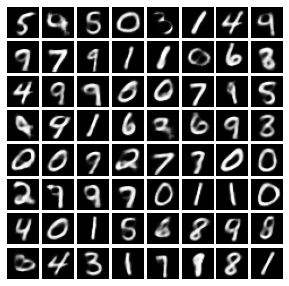

In [30]:
import matplotlib.gridspec as gridspec
print("Images generated by GMMN")
gmm_net = GMMN(NOISE_SIZE, ENCODED_SIZE)
gmm_net.load_state_dict(torch.load(GMMN_SAVE_PATH))
img_list = []
for r in range(2*N_ROWS):
    for c in range(N_COLS):
        noise = torch.rand((1, NOISE_SIZE)) * 2 - 1
        encoded_x = gmm_net(Variable(noise))
        y = encoder_net.decode(encoded_x)
        img_list.append(y.detach().squeeze().numpy().reshape(28, 28))

plt.figure(figsize = (5,5))
gs1 = gridspec.GridSpec(8, 8)
gs1.update(wspace=0.0, hspace=0.1)

for i in range(64):
    ax1 = plt.subplot(gs1[i])
    plt.imshow(img_list[i], cmap = 'gray')
    plt.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
plt.show()

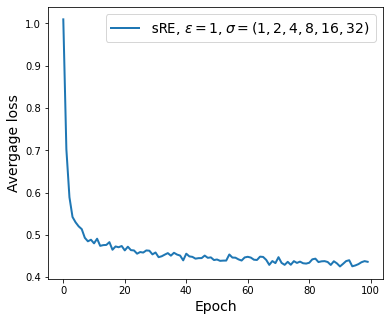

In [35]:
plt.figure(figsize = (6,5))
plt.plot(loss_list, linewidth = 2, label = r'$\mathtt{sRE}$, $\varepsilon = 1, \sigma = (1, 2, 4, 8, 16, 32)$')
plt.ylabel('Avergage loss', fontsize = 14)
plt.xlabel('Epoch',  fontsize = 14)
plt.legend(fontsize = 14)